In [2]:
# import the necessary libraries
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset

# import dataloader class
from torch.utils.data import DataLoader

from torchvision import transforms, datasets

# import visualisation tool
import matplotlib.pyplot as plt

# import time to time the training
import time

# import os for image loading outside torch
import os


In [3]:
# use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# define the dataset path
dataset_path = 'archive'
train_path = dataset_path + '/Training'
test_path = dataset_path + '/Testing'

# define the transforms
data_transform = transforms.Compose(
    [transforms.Resize((256, 256)), 
    transforms.ToTensor()])

# define the datasets using ImageFolder
train_dataset = datasets.ImageFolder(root=train_path, transform=data_transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=data_transform)

# define the dataloaders with the transforms
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

Using device: cuda


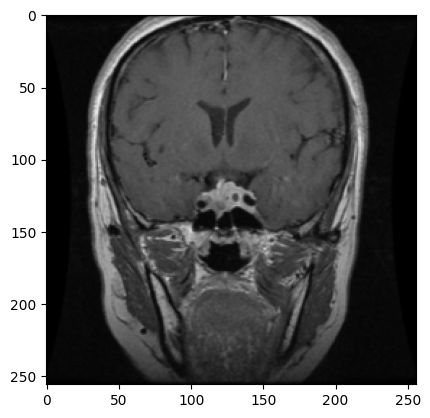

In [4]:
# show the first image in the train_loader dataset
data = next(iter(train_loader))
img = data[0][0]
plt.imshow(img.permute(1, 2, 0))

### Attempt 1: Simple CNN model with one Conv2D and one FC layer

In [5]:
# simple CNN model with one convolutional layer and one fully connected layer
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(16*128*128, 4))

if torch.cuda.is_available():
    model.to(device)
    train_loader_gpu = [(data.to(device), target.to(device)) for data, target in train_loader]
    test_loader_gpu = [(data.to(device), target.to(device)) for data, target in test_loader]
    
# define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train the model and time each epoch. The code should work with both CPU and GPU
n_epochs = 10
start_time = time.time()
train_temp = train_loader_gpu if torch.cuda.is_available() else train_loader
for epoch in range(n_epochs):
    model.train()    
    for data, target in train_temp:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{n_epochs} - Loss: {loss.item()}')
   

/home/adam/.conda/envs/torch/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1708025824022/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/10 - Loss: 0.6006995439529419
Epoch 2/10 - Loss: 0.3685954213142395
Epoch 3/10 - Loss: 0.11132176220417023
Epoch 4/10 - Loss: 0.32701829075813293
Epoch 5/10 - Loss: 0.011054961942136288
Epoch 6/10 - Loss: 0.01070459745824337
Epoch 7/10 - Loss: 0.005502364132553339
Epoch 8/10 - Loss: 0.004063069354742765
Epoch 9/10 - Loss: 0.0044024293310940266
Epoch 10/10 - Loss: 0.010732405818998814


In [6]:
# test the model accuracy
correct = 0
total = 0
model.eval()
test_temp = test_loader_gpu if torch.cuda.is_available() else test_loader
with torch.no_grad():
    for data, target in test_temp:
        output = model(data)
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
print(f'Accuracy: {100 * correct / total}%')
print(f'Time: {time.time() - start_time} seconds')


Accuracy: 77.15736040609137%
Time: 46.30336308479309 seconds


The accuracy is surprisingly high. We should be suspicious. We should check the following:
- Distribution of train and test classes
- Confusion matrix (precision/recall for each class) for the test set

In [7]:
# Let's see the distribution of the classes in the dataset for training first
class_distribution = {}
for _, target in train_loader:
    for label in target:
        if label.item() in class_distribution:
            class_distribution[label.item()] += 1
        else:
            class_distribution[label.item()] = 1
print("train", class_distribution)


# Let's see the distribution of the classes in the dataset for testing
class_distribution = {}
for _, target in test_loader:
    for label in target:
        if label.item() in class_distribution:
            class_distribution[label.item()] += 1
        else:
            class_distribution[label.item()] = 1
print("test", class_distribution)

train {0: 826, 1: 822, 3: 827, 2: 395}
test {2: 105, 1: 115, 0: 100, 3: 74}


<Axes: >

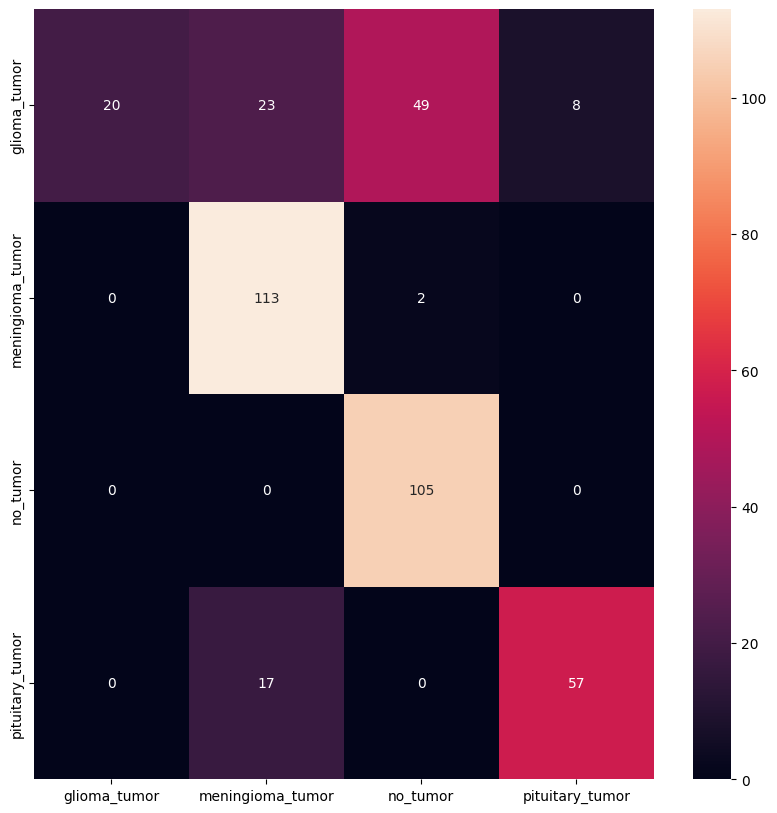

In [7]:
from matplotlib import pyplot as plt
import seaborn as sns

# we plot a confusion matrix to see the performance of the model
fig, ax = plt.subplots(figsize=(10, 10))
confusion_matrix = np.zeros((4, 4))
model.eval()
with torch.no_grad():
    for data, target in test_temp:
        output = model(data)
        _, predicted = torch.max(output, 1)
        for i in range(len(predicted)):
            confusion_matrix[target[i]][predicted[i]] += 1
# convert the confusion matrix to an integer 2d array
confusion_matrix = confusion_matrix.astype(int)
classes = train_dataset.classes
sns.heatmap(confusion_matrix, annot=True, fmt = 'd', xticklabels=classes, yticklabels=classes, ax=ax)

Our model seems to be having issues with classifying glioma tumors, but otherwise, surprisingly accurate

We can try a slightly more complicated framework using multiple convolution layers and multiple FC layers to see if a more complicated network performs better

## Attempt 2: Two-Conv and Two-FC

In [8]:
# we try again using a more complex model, we do two convolutional layers and two fully connected layers
model_cp = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(32*64*64, 128),
    nn.ReLU(),
    nn.Linear(128, 4))

# move the model to the GPU if available
model_cp.to(device)

# define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cp.parameters(), lr=0.001)

# train the model and time each epoch. The code should work with both CPU and GPU
n_epochs = 10
start_time = time.time()
train_temp = train_loader_gpu if torch.cuda.is_available() else train_loader
for epoch in range(n_epochs):
    model_cp.train()    
    for data, target in train_temp:
        optimizer.zero_grad()
        output = model_cp(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{n_epochs} - Loss: {loss.item()} performed in {time.time() - start_time} seconds')
    start_time = time.time()


Epoch 1/10 - Loss: 0.7187923789024353 performed in 2.9072587490081787 seconds
Epoch 2/10 - Loss: 0.5302128195762634 performed in 3.0563559532165527 seconds
Epoch 3/10 - Loss: 0.2383994162082672 performed in 3.4279706478118896 seconds
Epoch 4/10 - Loss: 0.143871009349823 performed in 3.4383976459503174 seconds
Epoch 5/10 - Loss: 0.2004430890083313 performed in 3.417487859725952 seconds
Epoch 6/10 - Loss: 0.09520456194877625 performed in 3.4027531147003174 seconds
Epoch 7/10 - Loss: 0.035501956939697266 performed in 3.4043490886688232 seconds
Epoch 8/10 - Loss: 0.054221250116825104 performed in 3.4062609672546387 seconds
Epoch 9/10 - Loss: 0.047546807676553726 performed in 3.406359910964966 seconds
Epoch 10/10 - Loss: 0.004859954584389925 performed in 3.4076881408691406 seconds


In [9]:
# test the model accuracy
correct = 0
total = 0
model_cp.eval()
test_temp = test_loader_gpu if torch.cuda.is_available() else test_loader
with torch.no_grad():
    for data, target in test_temp:
        output = model_cp(data)
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
print(f'Accuracy: {100 * correct / total}%')

Accuracy: 72.58883248730965%


We seem to have gotten more or less the same accuracy...

<Axes: >

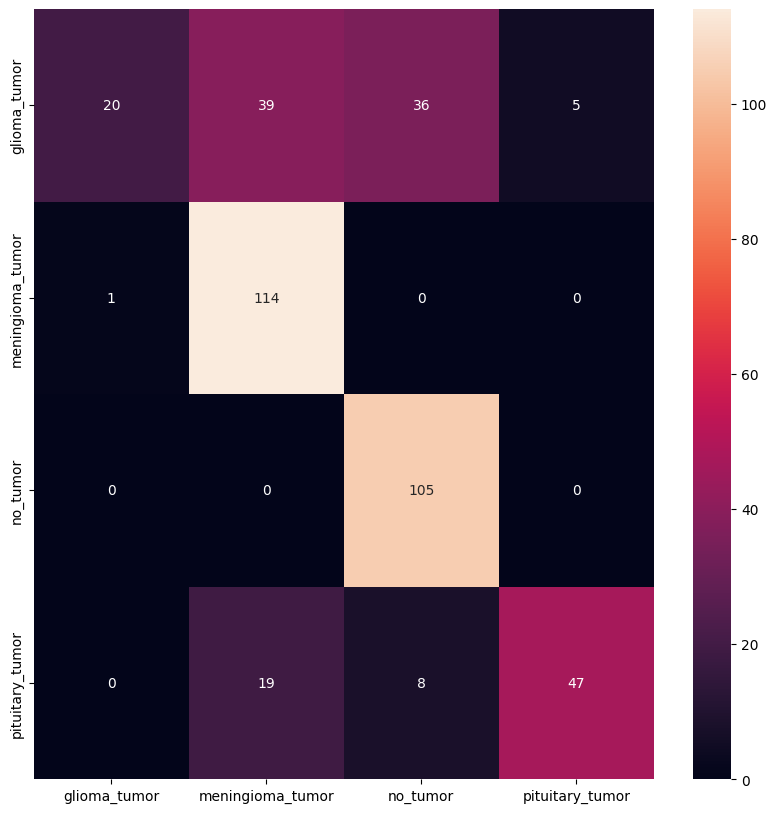

In [10]:
# plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
confusion_matrix = np.zeros((4, 4))
model_cp.eval()
with torch.no_grad():
    for data, target in test_temp:
        output = model_cp(data)
        _, predicted = torch.max(output, 1)
        for i in range(len(predicted)):
            confusion_matrix[target[i]][predicted[i]] += 1
# convert the confusion matrix to an integer 2d array
confusion_matrix = confusion_matrix.astype(int)
classes = train_dataset.classes
sns.heatmap(confusion_matrix, annot=True, fmt = 'd', xticklabels=classes, yticklabels=classes, ax=ax)

In [11]:
# we can try loading the images at a higher resolution, but we should check what the minimum dimensions are
min_x = 10000
min_y = 10000

for root, dirs, files in os.walk(train_path):
    for file in files:
        if file.endswith('.jpg'):
            img = plt.imread(os.path.join(root, file))
            x, y = img.shape[:2]
            min_x = min(x, min_x)
            min_y = min(y, min_y)

print(min_x, min_y)

198 180


Apparently, we're already overshooting our minimum dimensions! Just to see: what happens if we resize to a smaller resolution?

## Attempt 3: Smaller Image Transform

In [12]:
data_transform_sm = transforms.Compose(
    [transforms.Resize((128, 128)), 
    transforms.ToTensor()])

# define the new smaller datasets using ImageFolder
train_dataset_sm = datasets.ImageFolder(root=train_path, transform=data_transform_sm)
test_dataset_sm = datasets.ImageFolder(root=test_path, transform=data_transform_sm)

# define the new smaller dataloaders
train_loader_sm = DataLoader(dataset=train_dataset_sm, batch_size=32, shuffle=True)
test_loader_sm = DataLoader(dataset=test_dataset_sm, batch_size=32, shuffle=True)

# move to gpu if available
if torch.cuda.is_available():
    train_loader_gpu_sm = [(data.to(device), target.to(device)) for data, target in train_loader_sm]
    test_loader_gpu_sm = [(data.to(device), target.to(device)) for data, target in test_loader_sm]

In [13]:
# simple CNN model with one convolutional layer and one fully connected layer
model_sm = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(16*64*64, 4))

# move the model to the GPU if available
model_sm.to(device)

# define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_sm.parameters(), lr=0.001)

# train the model and time each epoch. The code should work with both CPU and GPU
n_epochs = 10
start_time = time.time()
first_start = start_time
train_temp = train_loader_gpu_sm if torch.cuda.is_available() else train_loader_sm
for epoch in range(n_epochs):
    model_sm.train()    
    for data, target in train_temp:
        optimizer.zero_grad()
        output = model_sm(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{n_epochs} - Loss: {loss.item()} performed in {time.time() - start_time} seconds')
    start_time = time.time()
print(f'Total Train Time: {time.time() - first_start} seconds')

Epoch 1/10 - Loss: 0.5542083978652954 performed in 0.41597986221313477 seconds
Epoch 2/10 - Loss: 0.2889448404312134 performed in 0.41530299186706543 seconds
Epoch 3/10 - Loss: 0.11798024922609329 performed in 0.41460299491882324 seconds
Epoch 4/10 - Loss: 0.07372310757637024 performed in 0.41521215438842773 seconds
Epoch 5/10 - Loss: 0.12446271628141403 performed in 0.4145779609680176 seconds
Epoch 6/10 - Loss: 0.0498453751206398 performed in 0.41507506370544434 seconds
Epoch 7/10 - Loss: 0.03725177422165871 performed in 0.4156010150909424 seconds
Epoch 8/10 - Loss: 0.028759997338056564 performed in 0.4154701232910156 seconds
Epoch 9/10 - Loss: 0.010376814752817154 performed in 0.41499948501586914 seconds
Epoch 10/10 - Loss: 0.007762616500258446 performed in 0.4145505428314209 seconds
Total Train Time: 4.15239405632019 seconds


In [14]:
# test the model accuracy
correct = 0
total = 0
model_sm.eval()
test_temp = test_loader_gpu_sm if torch.cuda.is_available() else test_loader_sm
with torch.no_grad():
    for data, target in test_temp:
        output = model_sm(data)
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
print(f'Accuracy: {100 * correct / total}%')

Accuracy: 72.84263959390863%


<Axes: >

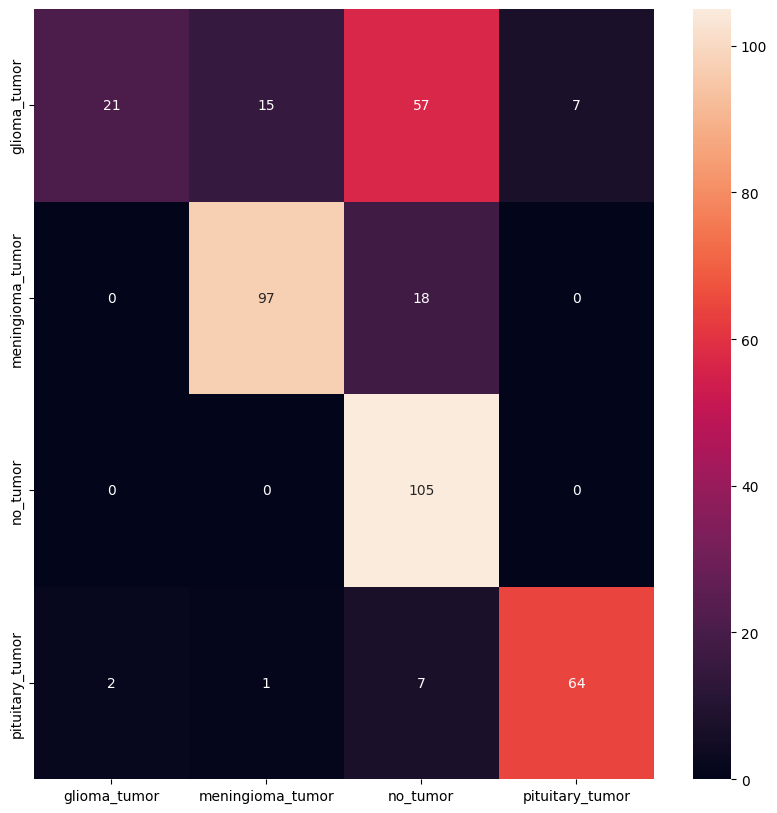

In [17]:
# plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
confusion_matrix = np.zeros((4, 4))
model.eval()
with torch.no_grad():
    for data, target in test_temp:
        output = model_sm(data)
        _, predicted = torch.max(output, 1)
        for i in range(len(predicted)):
            confusion_matrix[target[i]][predicted[i]] += 1
# convert the confusion matrix to an integer 2d array
confusion_matrix = confusion_matrix.astype(int)
classes = train_dataset.classes
sns.heatmap(confusion_matrix, annot=True, fmt = 'd', xticklabels=classes, yticklabels=classes, ax=ax)

Since we seem to be having issues with glioma tumours specifically with confusion against no tumours, we can try a two-step
classification. First, we see if there is a tumour. Then, we classify what kind of tumour it is

## Attempt 4: Two-Step Classification

In [18]:
# we try again, but classes 0,1,and 3 are merged into one class first
# we need to redefine the dataset and the dataloader

train_dataset_bin = datasets.ImageFolder(root=train_path, transform=data_transform_sm)
test_dataset_bin = datasets.ImageFolder(root=test_path, transform=data_transform_sm)

class_mapping = {0: 1, 1: 1, 2: 0, 3: 1}

class DatasetBinary(Dataset):
    def __init__(self, dataset, class_mapping):
        self.dataset = dataset
        self.class_mapping = class_mapping
        self.targets = [class_mapping[target] for _, target in self.dataset]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, target = self.dataset[idx]
        return data, self.class_mapping[target]

train_dataset_bin = DatasetBinary(train_dataset_bin, class_mapping)
test_dataset_bin = DatasetBinary(test_dataset_bin, class_mapping)

train_loader_bin = DataLoader(dataset=train_dataset_bin, batch_size=32, shuffle=True)
test_loader_bin = DataLoader(dataset=test_dataset_bin, batch_size=32, shuffle=True)


In [19]:
# we should check the distribution of the classes in the dataset
class_distribution = {}
for _, target in train_loader_bin:
    for label in target:
        if label.item() in class_distribution:
            class_distribution[label.item()] += 1
        else:
            class_distribution[label.item()] = 1
print("train", class_distribution)

train {1: 2475, 0: 395}


Huh, well the imbalance is certainly a problem. We can guard against this using a weighted sampler

In [11]:
from collections import Counter
from torch.utils.data import WeightedRandomSampler

# Calculate class weights as the inverse of their frequencies
class_counts = Counter(train_dataset_bin.targets)
total_samples = sum(class_counts.values())
class_weights = {class_idx: total_samples / count for class_idx, count in class_counts.items()}

# Calculate sampling weights for each instance in the dataset
sample_weights = [class_weights[target] for target in train_dataset_bin.targets]

# Define the sampler for the DataLoader
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Define the DataLoader with the sampler
train_loader_bin_weighted = DataLoader(dataset=train_dataset_bin, batch_size=64, sampler=sampler)

NameError: name 'train_dataset_bin' is not defined

In [21]:
# distribution of the classes in the dataset
class_distribution = {}
for _, target in train_loader_bin_weighted:
    for label in target:
        if label.item() in class_distribution:
            class_distribution[label.item()] += 1
        else:
            class_distribution[label.item()] = 1
print("train", class_distribution)

train {1: 1396, 0: 1474}


Looks good! We can start training

In [22]:
# move the loaders to the GPU if available
if torch.cuda.is_available():
    train_loader_gpu_bin = [(data.to(device), target.to(device)) for data, target in train_loader_bin_weighted]
    test_loader_gpu_bin = [(data.to(device), target.to(device)) for data, target in test_loader_bin]


# simple CNN model with one convolutional layer and one fully connected layer
model_bin = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(16*64*64, 2))

# move the model to the GPU if available
model_bin.to(device)

# define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_bin.parameters(), lr=0.001)

# train the model and time each epoch. The code should work with both CPU and GPU
n_epochs = 10
start_time = time.time()
first_start = start_time
train_temp = train_loader_gpu_bin if torch.cuda.is_available() else train_loader_bin
for epoch in range(n_epochs):
    model_bin.train()    
    for data, target in train_temp:
        optimizer.zero_grad()
        output = model_bin(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{n_epochs} - Loss: {loss.item()} performed in {time.time() - start_time} seconds')
    start_time = time.time()
print(f'Total Train Time: {time.time() - first_start} seconds')

Epoch 1/10 - Loss: 0.26225683093070984 performed in 0.3538367748260498 seconds
Epoch 2/10 - Loss: 0.1076238602399826 performed in 0.37372493743896484 seconds
Epoch 3/10 - Loss: 0.05174674838781357 performed in 0.39186882972717285 seconds
Epoch 4/10 - Loss: 0.03779497742652893 performed in 0.3925507068634033 seconds
Epoch 5/10 - Loss: 0.03549017384648323 performed in 0.39156174659729004 seconds
Epoch 6/10 - Loss: 0.021239005029201508 performed in 0.3925471305847168 seconds
Epoch 7/10 - Loss: 0.013201052322983742 performed in 0.3922135829925537 seconds
Epoch 8/10 - Loss: 0.008891112171113491 performed in 0.3923966884613037 seconds
Epoch 9/10 - Loss: 0.006896498613059521 performed in 0.39278244972229004 seconds
Epoch 10/10 - Loss: 0.005549135617911816 performed in 0.391660213470459 seconds
Total Train Time: 3.8658430576324463 seconds


In [23]:
# test the model accuracy
correct = 0
total = 0
model_bin.eval()
test_temp = test_loader_gpu_bin if torch.cuda.is_available() else test_loader_bin
with torch.no_grad():
    for data, target in test_temp:
        output = model_bin(data)
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
print(f'Accuracy: {100 * correct / total}%')

Accuracy: 73.60406091370558%


<Axes: >

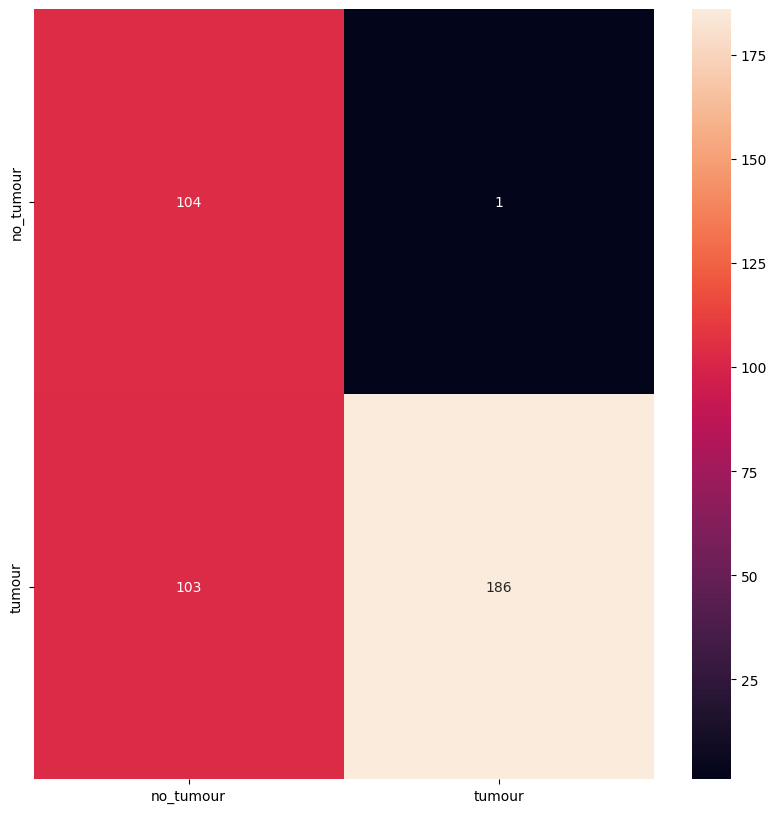

In [24]:
# plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
confusion_matrix = np.zeros((2, 2))
model_bin.eval()
with torch.no_grad():
    for data, target in test_temp:
        output = model_bin(data)
        _, predicted = torch.max(output, 1)
        for i in range(len(predicted)):
            confusion_matrix[target[i]][predicted[i]] += 1
# convert the confusion matrix to an integer 2d array
confusion_matrix = confusion_matrix.astype(int)
classes = ['no_tumour', 'tumour']
sns.heatmap(confusion_matrix, annot=True, fmt = 'd', xticklabels=classes, yticklabels=classes, ax=ax)

That's not great. We should try a slightly more complicated model next time, but this 2-step classification is promising

## Attempt 4b: Using a Dropout layer to help prevent overfitting of the no_tumour class

In [25]:
# the model is overfitting, we can try to add dropout layers and also use more convolutional layers
model_bin_dropout = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(0.5),
    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(0.5),
    nn.Flatten(),
    nn.Linear(32*32*32, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 2))

# move the model to the GPU if available
model_bin_dropout.to(device)

# define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_bin_dropout.parameters(), lr=0.001)

In [26]:
# train the model and time each epoch. The code should work with both CPU and GPU
n_epochs = 25
start_time = time.time()
first_start = start_time
train_temp = train_loader_gpu_bin if torch.cuda.is_available() else train_loader_bin

for epoch in range(n_epochs):
    model_bin_dropout.train()    
    for data, target in train_temp:
        optimizer.zero_grad()
        output = model_bin_dropout(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{n_epochs} - Loss: {loss.item()} performed in {time.time() - start_time} seconds')
    start_time = time.time()
print(f'Total Train Time: {time.time() - first_start} seconds')


Epoch 1/25 - Loss: 0.47458937764167786 performed in 0.8400778770446777 seconds
Epoch 2/25 - Loss: 0.32207274436950684 performed in 0.8356726169586182 seconds
Epoch 3/25 - Loss: 0.32695186138153076 performed in 0.8337337970733643 seconds
Epoch 4/25 - Loss: 0.18571048974990845 performed in 0.833554744720459 seconds
Epoch 5/25 - Loss: 0.22095687687397003 performed in 0.834230899810791 seconds
Epoch 6/25 - Loss: 0.15829411149024963 performed in 0.829686164855957 seconds
Epoch 7/25 - Loss: 0.14327548444271088 performed in 0.8353145122528076 seconds
Epoch 8/25 - Loss: 0.07921011000871658 performed in 0.8319094181060791 seconds
Epoch 9/25 - Loss: 0.1205756738781929 performed in 0.8320107460021973 seconds
Epoch 10/25 - Loss: 0.08105774223804474 performed in 0.8337066173553467 seconds
Epoch 11/25 - Loss: 0.07683274149894714 performed in 0.8346898555755615 seconds
Epoch 12/25 - Loss: 0.043919555842876434 performed in 0.8346152305603027 seconds
Epoch 13/25 - Loss: 0.18692167103290558 performed in

In [27]:
# test the model accuracy
correct = 0
total = 0
model_bin_dropout.eval()
test_temp = test_loader_gpu_bin if torch.cuda.is_available() else test_loader_bin
with torch.no_grad():
    for data, target in test_temp:
        output = model_bin_dropout(data)
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
print(f'Accuracy: {100 * correct / total}%')

Accuracy: 67.51269035532995%


<Axes: >

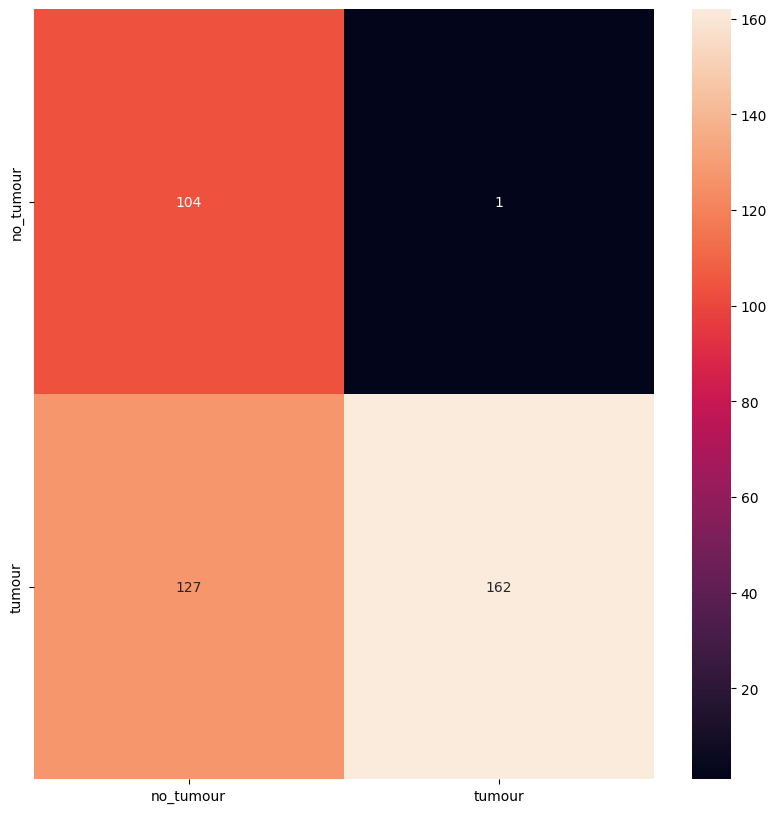

In [28]:
# plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
confusion_matrix = np.zeros((2, 2))
model_bin_dropout.eval()
with torch.no_grad():
    for data, target in test_temp:
        output = model_bin_dropout(data)
        _, predicted = torch.max(output, 1)
        for i in range(len(predicted)):
            confusion_matrix[target[i]][predicted[i]] += 1
# convert the confusion matrix to an integer 2d array
confusion_matrix = confusion_matrix.astype(int)
classes = ['no_tumour', 'tumour']
sns.heatmap(confusion_matrix, annot=True, fmt = 'd', xticklabels=classes, yticklabels=classes, ax=ax)


<Axes: >

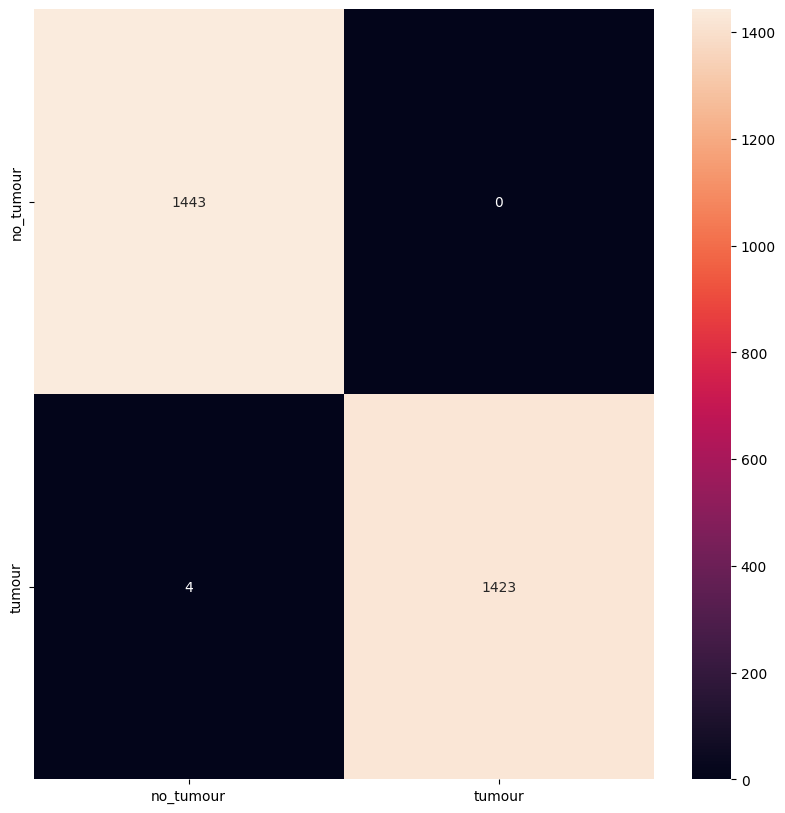

In [29]:
# just to be sure, let's plot the confusion matrix for the training set too
fig, ax = plt.subplots(figsize=(10, 10))
confusion_matrix = np.zeros((2, 2))
model_bin_dropout.eval()
with torch.no_grad():
    for data, target in train_temp:
        output = model_bin_dropout(data)
        _, predicted = torch.max(output, 1)
        for i in range(len(predicted)):
            confusion_matrix[target[i]][predicted[i]] += 1
# convert the confusion matrix to an integer 2d array
confusion_matrix = confusion_matrix.astype(int)
classes = ['no_tumour', 'tumour']
sns.heatmap(confusion_matrix, annot=True, fmt = 'd', xticklabels=classes, yticklabels=classes, ax=ax)


Clearly, our CNN isn't learning much about the visual properties of the images at all...

In [12]:
# we should try using the original resolution with the binary classes

data_transform = transforms.Compose(
    [transforms.Resize((256, 256)), 
    transforms.ToTensor()])

class DatasetBinary(Dataset):
    def __init__(self, dataset, class_mapping):
        self.dataset = dataset
        self.class_mapping = class_mapping
        self.targets = [class_mapping[target] for _, target in self.dataset]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, target = self.dataset[idx]
        return data, self.class_mapping[target]

class_mapping = {0: 1, 1: 1, 2: 0, 3: 1}


train_dataset_bin_256 = datasets.ImageFolder(root=train_path, transform=data_transform)
test_dataset_bin_256 = datasets.ImageFolder(root=test_path, transform=data_transform)

train_dataset_bin_256 = DatasetBinary(train_dataset_bin_256, class_mapping)
test_dataset_bin_256 = DatasetBinary(test_dataset_bin_256, class_mapping)

# Calculate class weights as the inverse of their frequencies
class_counts = Counter(train_dataset_bin_256.targets)
total_samples = sum(class_counts.values())
class_weights = {class_idx: total_samples / count for class_idx, count in class_counts.items()}

# Calculate sampling weights for each instance in the dataset
sample_weights = [class_weights[target] for target in train_dataset_bin_256.targets]

# Define the sampler for the DataLoader
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader_bin_256 = DataLoader(dataset=train_dataset_bin_256, batch_size=32, sampler = sampler)
test_loader_bin_256 = DataLoader(dataset=test_dataset_bin_256, batch_size=32, shuffle=True)


In [13]:
# distribution of the classes in the dataset
class_distribution = {}
for _, target in train_loader_bin_256:
    for label in target:
        if label.item() in class_distribution:
            class_distribution[label.item()] += 1
        else:
            class_distribution[label.item()] = 1
print("train", class_distribution)

train {0: 1422, 1: 1448}


In [16]:
# move the loaders to the GPU if available
if torch.cuda.is_available():
    train_loader_gpu_bin_256 = [(data.to(device), target.to(device)) for data, target in train_loader_bin_256]
    test_loader_gpu_bin_256 = [(data.to(device), target.to(device)) for data, target in test_loader_bin_256]

# simple CNN model with one convolutional layer and one fully connected layer
model_bin_256 = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(16*128*128, 2))

model_bin_256.to(device)


OutOfMemoryError: CUDA out of memory. Tried to allocate 24.00 MiB. GPU 0 has a total capacity of 5.78 GiB of which 4.25 MiB is free. Including non-PyTorch memory, this process has 5.72 GiB memory in use. Of the allocated memory 5.54 GiB is allocated by PyTorch, and 52.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [17]:
# define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_bin_256.parameters(), lr=0.001)



In [18]:
# train the model and time each epoch. The code should work with both CPU and GPU
n_epochs = 10
start_time = time.time()
first_start = start_time
train_temp = train_loader_gpu_bin_256 if torch.cuda.is_available() else train_loader_bin_256
for epoch in range(n_epochs):
    model_bin_256.train()    
    for data, target in train_temp:
        optimizer.zero_grad()
        output = model_bin_256(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{n_epochs} - Loss: {loss.item()} performed in {time.time() - start_time} seconds')
    start_time = time.time()
print(f'Total Train Time: {time.time() - first_start} seconds')

Epoch 1/10 - Loss: 0.09841904789209366 performed in 1.239558219909668 seconds
Epoch 2/10 - Loss: 0.015263301320374012 performed in 1.2075777053833008 seconds
Epoch 3/10 - Loss: 0.00833601038902998 performed in 1.2071313858032227 seconds
Epoch 4/10 - Loss: 0.0038002794608473778 performed in 1.2068743705749512 seconds
Epoch 5/10 - Loss: 0.0026424655225127935 performed in 1.2095646858215332 seconds
Epoch 6/10 - Loss: 0.0015092509565874934 performed in 1.2107443809509277 seconds
Epoch 7/10 - Loss: 0.0011372703593224287 performed in 1.2123615741729736 seconds
Epoch 8/10 - Loss: 0.0008335279417224228 performed in 1.213606834411621 seconds
Epoch 9/10 - Loss: 0.0007761098095215857 performed in 1.214235544204712 seconds
Epoch 10/10 - Loss: 0.0006175562157295644 performed in 1.2151875495910645 seconds
Total Train Time: 12.137551546096802 seconds


In [19]:
# test the model accuracy
correct = 0
total = 0
model_bin_256.eval()
test_temp = test_loader_gpu_bin_256 if torch.cuda.is_available() else test_loader_bin_256
with torch.no_grad():
    for data, target in test_temp:
        output = model_bin_256(data)
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
print(f'Accuracy: {100 * correct / total}%')


Accuracy: 75.63451776649747%


In [22]:
import seaborn as sns

<Axes: >

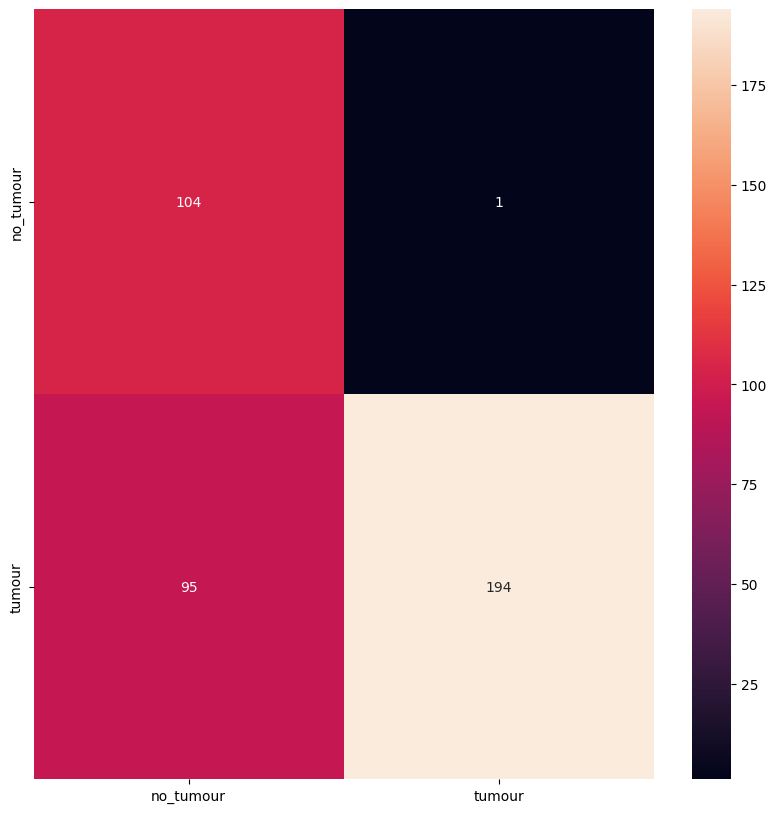

In [23]:
# plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
confusion_matrix = np.zeros((2, 2))
model_bin_256.eval()
with torch.no_grad():
    for data, target in test_temp:
        output = model_bin_256(data)
        _, predicted = torch.max(output, 1)
        for i in range(len(predicted)):
            confusion_matrix[target[i]][predicted[i]] += 1
# convert the confusion matrix to an integer 2d array
confusion_matrix = confusion_matrix.astype(int)
classes = ['no_tumour', 'tumour']
sns.heatmap(confusion_matrix, annot=True, fmt = 'd', xticklabels=classes, yticklabels=classes, ax=ax)

## We will try pretrained models next time to see if we can make any headway on the image features

In [ ]:
# we might want to detect a tumour first, and then afterwards classify it
# we can refer to this https://github.com/kondratevakate/mri-deep-learning-tools maybe for insight or techniques
# we can also try to segment the image first to locate the tumour, then train the classifier on the segmented images



In [ ]:
torch.cuda.is_available() # check if cuda is available

True